# Wildfire Analysis

Wildfire data: [Kaggle](https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires)

Wildfire weather data: [Kaggle](https://www.kaggle.com/datasets/leternnoz/188-million-us-wildfires-weather-data)

## Import libraries

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report #tuning report for classifiers
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

pd.set_option('display.max_columns', None)
sns.set_theme()
sns.set_palette('colorblind')

## Import data

In [2]:
df = pd.read_csv('merged_df.csv')
df.head()

/tmp/ipykernel_21987/3330149865.py:1: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,18,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_df.csv')


,objectid,fod_id,fpa_id,source_system_type,source_system,nwcg_reporting_agency,nwcg_reporting_unit_id,nwcg_reporting_unit_name,source_reporting_unit,source_reporting_unit_name,local_fire_report_id,local_incident_id,fire_code,fire_name,ics_209_incident_number,ics_209_name,mtbs_id,mtbs_fire_name,complex_name,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,owner_code,owner_descr,state,county,fips_code,fips_name,shape,temp_mean_0,prcp_sum_0,wspd_mean_0,temp_mean_10,prcp_sum_10,wspd_mean_10,temp_mean_30,prcp_sum_30,wspd_mean_20,temp_mean_60,prcp_sum_60,wspd_mean_60,temp_mean_180,prcp_sum_180,wspd_mean_180
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,NaN,NaN,NaN,NaN,NaN,2005,2453403.5,33,1300.0,9.0,Miscellaneous,2453403.5,33.0,1730.0,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63.0,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,6.9,0.0,19.3,3.970,0.0,14.170000,4.646667,39.05,10.910714,4.668421,94.9,11.946154,9.828977,287.05,10.686905
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,13,AAC0,PIGEON,NaN,NaN,NaN,NaN,NaN,2004,2453137.5,133,845.0,1.0,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61.0,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,6.8,0.0,9.5,10.155,5.5,13.870000,8.133333,6.00,13.038333,8.100847,6.0,11.572881,3.219101,107.50,10.496348
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,27,021,A32W,SLACK,NaN,NaN,NaN,NaN,NaN,2004,2453156.5,152,1921.0,5.0,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17.0,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,17.3,0.0,NaN,12.030,0.0,9.711111,11.323333,5.50,10.455172,10.087931,6.0,11.286538,6.210651,107.50,10.915244
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,43,6,NaN,DEER,NaN,NaN,NaN,NaN,NaN,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,44,7,NaN,STEVENOT,NaN,NaN,NaN,NaN,NaN,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105


In [3]:
df.shape

(1830945, 54)

## Exploratory Data Analysis

In [4]:
# check number of duplicates
print('Number of duplicated rows: ', df.duplicated().sum())

# drop duplicates
print('Number of rows before dropping duplicates: ', len(df))
df.drop_duplicates(inplace=True)
print('Number of rows after dropping duplicates: ', len(df))

Number of duplicated rows:  18
Number of rows before dropping duplicates:  1830945
Number of rows after dropping duplicates:  1830927


In [5]:
# check number of missing values per column
df.isnull().sum()

objectid                            0
fod_id                              0
fpa_id                              0
source_system_type                  0
source_system                       0
nwcg_reporting_agency               0
nwcg_reporting_unit_id              0
nwcg_reporting_unit_name            0
source_reporting_unit               0
source_reporting_unit_name          0
local_fire_report_id          1415632
local_incident_id              788503
fire_code                     1509471
fire_name                      923478
ics_209_incident_number       1805297
ics_209_name                  1805298
mtbs_id                       1819962
mtbs_fire_name                1819962
complex_name                  1825791
fire_year                           0
discovery_date                      0
discovery_doy                       0
discovery_time                 849910
stat_cause_code                     0
stat_cause_descr                    0
cont_date                      858023
cont_doy    

In [6]:
# check the percentage of missing values per column
columns_nulls = round(df.isnull().sum() / len(df), 2)
columns_nulls

objectid                      0.00
fod_id                        0.00
fpa_id                        0.00
source_system_type            0.00
source_system                 0.00
nwcg_reporting_agency         0.00
nwcg_reporting_unit_id        0.00
nwcg_reporting_unit_name      0.00
source_reporting_unit         0.00
source_reporting_unit_name    0.00
local_fire_report_id          0.77
local_incident_id             0.43
fire_code                     0.82
fire_name                     0.50
ics_209_incident_number       0.99
ics_209_name                  0.99
mtbs_id                       0.99
mtbs_fire_name                0.99
complex_name                  1.00
fire_year                     0.00
discovery_date                0.00
discovery_doy                 0.00
discovery_time                0.46
stat_cause_code               0.00
stat_cause_descr              0.00
cont_date                     0.47
cont_doy                      0.47
cont_time                     0.51
fire_size           

In [7]:
# get columns name that have >70% of data missing
cols_to_drop = columns_nulls[columns_nulls > 0.7].index.to_list()
cols_to_drop

['local_fire_report_id',
 'fire_code',
 'ics_209_incident_number',
 'ics_209_name',
 'mtbs_id',
 'mtbs_fire_name',
 'complex_name']

In [8]:
# drop the columns
cleaned_df = df.drop(cols_to_drop, axis=1)
cleaned_df.columns


Index(['objectid', 'fod_id', 'fpa_id', 'source_system_type', 'source_system',
       'nwcg_reporting_agency', 'nwcg_reporting_unit_id',
       'nwcg_reporting_unit_name', 'source_reporting_unit',
       'source_reporting_unit_name', 'local_incident_id', 'fire_name',
       'fire_year', 'discovery_date', 'discovery_doy', 'discovery_time',
       'stat_cause_code', 'stat_cause_descr', 'cont_date', 'cont_doy',
       'cont_time', 'fire_size', 'fire_size_class', 'latitude', 'longitude',
       'owner_code', 'owner_descr', 'state', 'county', 'fips_code',
       'fips_name', 'shape', 'temp_mean_0', 'prcp_sum_0', 'wspd_mean_0',
       'temp_mean_10', 'prcp_sum_10', 'wspd_mean_10', 'temp_mean_30',
       'prcp_sum_30', 'wspd_mean_20', 'temp_mean_60', 'prcp_sum_60',
       'wspd_mean_60', 'temp_mean_180', 'prcp_sum_180', 'wspd_mean_180'],
      dtype='object')

In [9]:
cleaned_df.head()

,objectid,fod_id,fpa_id,source_system_type,source_system,nwcg_reporting_agency,nwcg_reporting_unit_id,nwcg_reporting_unit_name,source_reporting_unit,source_reporting_unit_name,local_incident_id,fire_name,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,owner_code,owner_descr,state,county,fips_code,fips_name,shape,temp_mean_0,prcp_sum_0,wspd_mean_0,temp_mean_10,prcp_sum_10,wspd_mean_10,temp_mean_30,prcp_sum_30,wspd_mean_20,temp_mean_60,prcp_sum_60,wspd_mean_60,temp_mean_180,prcp_sum_180,wspd_mean_180
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,PNF-47,FOUNTAIN,2005,2453403.5,33,1300.0,9.0,Miscellaneous,2453403.5,33.0,1730.0,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63.0,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,6.9,0.0,19.3,3.970,0.0,14.170000,4.646667,39.05,10.910714,4.668421,94.9,11.946154,9.828977,287.05,10.686905
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,PIGEON,2004,2453137.5,133,845.0,1.0,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61.0,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,6.8,0.0,9.5,10.155,5.5,13.870000,8.133333,6.00,13.038333,8.100847,6.0,11.572881,3.219101,107.50,10.496348
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,021,SLACK,2004,2453156.5,152,1921.0,5.0,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17.0,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,17.3,0.0,NaN,12.030,0.0,9.711111,11.323333,5.50,10.455172,10.087931,6.0,11.286538,6.210651,107.50,10.915244
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,6,DEER,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,7,STEVENOT,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105


#### Most Frequent Causes of Wildfires

In [10]:
cause_counts = cleaned_df['stat_cause_descr'].value_counts()
cause_counts

stat_cause_descr
Debris Burning       424854
Miscellaneous        319534
Lightning            276260
Arson                273421
Equipment Use        144483
Missing/Undefined    142838
Campfire              75178
Children              60241
Smoking               52562
Railroad              32077
Powerline             14411
Fireworks             11303
Structure              3765
Name: count, dtype: int64

/tmp/ipykernel_21987/1389342240.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


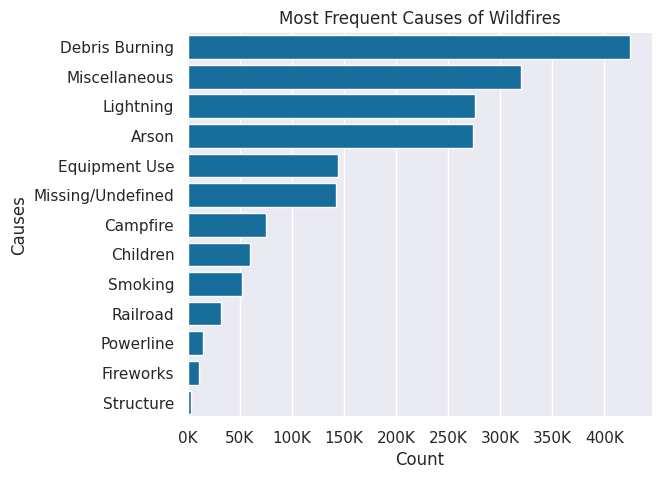

In [11]:
fig, ax = plt.subplots(figsize=(6,5))

g = sns.barplot(y=cause_counts.index, x=cause_counts.values)
g.set(title='Most Frequent Causes of Wildfires', xlabel='Count', ylabel='Causes')

xlabels = ['{:.0f}'.format(x) + 'K' for x in g.get_xticks()/1000]
g.set_xticklabels(xlabels)

plt.show()

#### Number of Wildfires per State

In [12]:
wildfires_per_state = cleaned_df['state'].value_counts()
wildfires_per_state

state
CA    185676
GA    163442
TX    141770
NC    110361
FL     88841
SC     80429
NY     80110
MS     79193
AZ     70130
AL     63626
OR     60676
MN     43909
OK     41637
MT     40499
NM     37265
ID     36499
CO     33719
WA     33375
WI     31372
AR     31311
TN     30901
SD     30705
UT     30541
LA     29080
KY     26969
NJ     25531
WV     21905
VA     21735
MO     17526
NV     16745
ND     14977
WY     14121
ME     13029
AK     12801
MI     10439
HI      9870
PA      8677
NE      7892
KS      7395
CT      4628
IA      4079
MD      3607
OH      3441
MA      2559
NH      2380
IL      2304
IN      2086
RI       480
VT       449
DE       170
DC        65
Name: count, dtype: int64

/tmp/ipykernel_21987/439658321.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


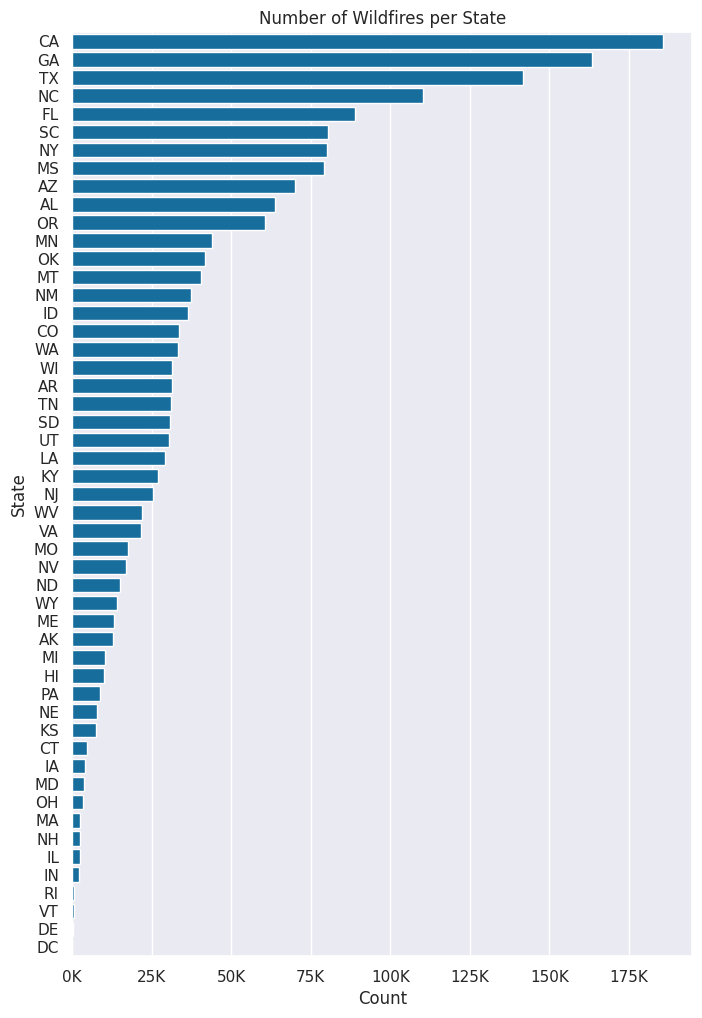

In [13]:
fig, ax = plt.subplots(figsize=(8,12))

g = sns.barplot(y=wildfires_per_state.index, x=wildfires_per_state.values)
g.set(title='Number of Wildfires per State', xlabel='Count', ylabel='State')

xlabels = ['{:.0f}'.format(x) + 'K' for x in g.get_xticks()/1000]
g.set_xticklabels(xlabels)

plt.show()

#### Fire Size Counts

In [14]:
fire_sizes = cleaned_df['fire_size_class'].value_counts()
fire_sizes

fire_size_class
B    908052
A    654739
C    214619
D     28037
E     13965
F      7753
G      3762
Name: count, dtype: int64

/tmp/ipykernel_21987/1113686665.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(xlabels)


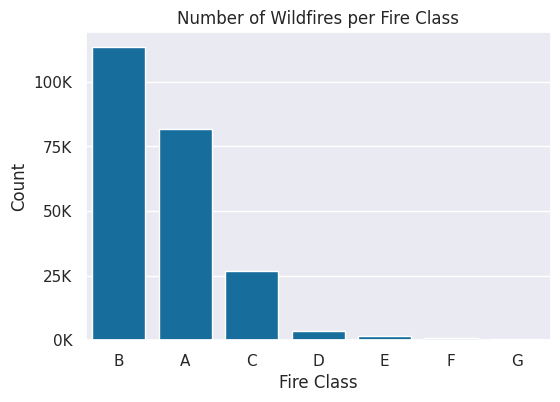

In [15]:
'''
`fire_size_class`: Code for fire size based on the number of acres within the final fire perimeter expenditures.
A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres,
D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres
'''

fig, ax = plt.subplots(figsize=(6, 4))

g = sns.barplot(x=fire_sizes.index, y=fire_sizes.values)
g.set(title='Number of Wildfires per Fire Class', xlabel='Fire Class', ylabel='Count')

ylabels = ['{:.0f}'.format(x) + 'K' for x in g.get_yticks()/1000]
g.set_yticklabels(xlabels)

plt.show()

In [27]:
wildfires_causes_df = cleaned_df[['stat_cause_code', 'stat_cause_descr']]
wildfires_causes_df = wildfires_causes_df.drop_duplicates()
wildfires_causes_df = wildfires_causes_df.reset_index(drop=True)
wildfires_causes_df["stat_cause_code"] = wildfires_causes_df.stat_cause_code.astype(int)
wildfires_causes_df

,stat_cause_code,stat_cause_descr
0,9,Miscellaneous
1,1,Lightning
2,5,Debris Burning
3,4,Campfire
4,2,Equipment Use
5,7,Arson
6,8,Children
7,6,Railroad
8,3,Smoking
9,11,Powerline


## Testing using Basic Model

In [35]:
cleaned_df.head()

,objectid,fod_id,fpa_id,source_system_type,source_system,nwcg_reporting_agency,nwcg_reporting_unit_id,nwcg_reporting_unit_name,source_reporting_unit,source_reporting_unit_name,local_incident_id,fire_name,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,owner_code,owner_descr,state,county,fips_code,fips_name,shape,temp_mean_0,prcp_sum_0,wspd_mean_0,temp_mean_10,prcp_sum_10,wspd_mean_10,temp_mean_30,prcp_sum_30,wspd_mean_20,temp_mean_60,prcp_sum_60,wspd_mean_60,temp_mean_180,prcp_sum_180,wspd_mean_180
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,PNF-47,FOUNTAIN,2005,2453403.5,33,1300.0,9.0,Miscellaneous,2453403.5,33.0,1730.0,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63.0,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,6.9,0.0,19.3,3.970,0.0,14.170000,4.646667,39.05,10.910714,4.668421,94.9,11.946154,9.828977,287.05,10.686905
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,PIGEON,2004,2453137.5,133,845.0,1.0,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61.0,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,6.8,0.0,9.5,10.155,5.5,13.870000,8.133333,6.00,13.038333,8.100847,6.0,11.572881,3.219101,107.50,10.496348
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,021,SLACK,2004,2453156.5,152,1921.0,5.0,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17.0,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,17.3,0.0,NaN,12.030,0.0,9.711111,11.323333,5.50,10.455172,10.087931,6.0,11.286538,6.210651,107.50,10.915244
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,6,DEER,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,7,STEVENOT,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105


In [36]:
# select features and target variable
selected_features = ['fire_year', 'discovery_time', 'fire_size', 'latitude', 'longitude', 'temp_mean_0',
                     'prcp_sum_0', 'wspd_mean_0', 'temp_mean_10', 'prcp_sum_10', 'wspd_mean_10', 'temp_mean_30',
                     'prcp_sum_30', 'wspd_mean_20', 'temp_mean_60', 'prcp_sum_60', 'wspd_mean_60', 'temp_mean_180',
                     'prcp_sum_180', 'wspd_mean_180']

X = cleaned_df[selected_features]
y = cleaned_df['stat_cause_code']

In [37]:
# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=173)

In [38]:
# train model
model = RandomForestClassifier()

model.fit(X_train, y_train)

RandomForestClassifier()

In [39]:
# get predicted value on testing set
y_pred = model.predict(X_test)

In [40]:
# get accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score: %f" % accuracy)

Accuracy Score: 0.569183


In [41]:
# get feature importance
feature_importance = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_,
                                             'feature':selected_features}).sort_values('feature_importance', ascending=False)
feature_importance

,feature_importance,feature
4,0.165110,longitude
3,0.131062,latitude
1,0.057764,discovery_time
2,0.056157,fire_size
0,0.054329,fire_year
17,0.045979,temp_mean_180
8,0.044293,temp_mean_10
11,0.043109,temp_mean_30
19,0.042591,wspd_mean_180
14,0.041574,temp_mean_60


## Build Model

### Data Cleaning & Feature Engineering

In [16]:
# Convert cont_time to string type
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy of a slice from a DataFrame.", category=SettingWithCopyWarning)

c_model = cleaned_df[["fire_year","discovery_doy","discovery_time","discovery_date","cont_doy","cont_time",
              "stat_cause_code","stat_cause_descr","fire_size","latitude","longitude","state","fips_name"]]
c_model["cont_time"] = c_model["cont_time"].astype(str)
c_model["combined_date_dis"] = pd.to_datetime(c_model["fire_year"] * 1000 + c_model["discovery_doy"], format="%Y%j")
c_model["combined_date_dis"] = c_model["combined_date_dis"].astype(str) + " " + c_model["discovery_time"].astype(str).str[:2] + ":" + c_model["discovery_time"].astype(str).str[2:]
c_model["combined_date_dis"] = pd.to_datetime(c_model["combined_date_dis"], errors="coerce")
c_model["combined_date_con"] = pd.to_datetime(c_model["fire_year"] * 1000 + c_model["cont_doy"], format="%Y%j", errors="ignore")
c_model["combined_date_con"] = c_model["combined_date_con"].astype(str) + " " + c_model["cont_time"].str[:2] + ":" + c_model["cont_time"].str[2:]
c_model["combined_date_con"] = pd.to_datetime(c_model["combined_date_con"], errors="coerce")
c_model["duration"] = (c_model["combined_date_con"] - c_model["combined_date_dis"]).dt.seconds / 60
c_model["week_day"] = c_model["combined_date_dis"].dt.weekday
c_model["month"] = c_model["combined_date_dis"].dt.month
c_model = c_model.set_index("combined_date_dis")

c_model["stat_cause_code"] = c_model.stat_cause_code.astype(int)
# Training the model based on features ["fire_year","stat_cause_descr","fire_size","latitude","longitude","fips_name","state","duration","week_day","month"]
c_model = c_model[["fire_year","stat_cause_code","fire_size","latitude","longitude","fips_name",
                   "state","duration","week_day","month"]]

/tmp/ipykernel_21987/3605614827.py:10: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  c_model["combined_date_con"] = pd.to_datetime(c_model["fire_year"] * 1000 + c_model["cont_doy"], format="%Y%j", errors="ignore")
/tmp/ipykernel_21987/3605614827.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  c_model["combined_date_con"] = pd.to_datetime(c_model["combined_date_con"], errors="coerce")


In [17]:
# remove misc/missing
c_model = c_model[~c_model['stat_cause_code'].isin([9, 13])]

print(c_model['stat_cause_code'])

combined_date_dis
NaT                    1
2004-05-31 19:00:21    5
2004-06-28 16:00:00    1
2004-06-28 16:00:00    1
2004-06-30 18:00:00    1
                      ..
2015-06-06 12:00:08    2
NaT                    5
NaT                    8
2015-09-30 23:00:57    7
2015-08-01 13:00:31    1
Name: stat_cause_code, Length: 1368555, dtype: int64


### Encode labels

In [18]:
# label encoding
fipslabelencode = LabelEncoder()
fips_labels = fipslabelencode.fit_transform(c_model.fips_name)
c_model["fips_name"] = fips_labels
statelabelencoders = LabelEncoder()
state_labels = statelabelencoders.fit_transform(c_model.state)
c_model["state"] = state_labels

c_model = c_model.dropna()
c_model.head()

,fire_year,stat_cause_code,fire_size,latitude,longitude,fips_name,state,duration,week_day,month
combined_date_dis,,,,,,,,,,
2004-05-31 19:00:21,2004,5,0.1,38.984167,-120.735556,486,4,83.65,0.0,5.0
2004-06-28 16:00:00,2004,1,0.1,38.559167,-119.913333,28,4,1320.00,0.0,6.0
2004-06-28 16:00:00,2004,1,0.1,38.559167,-119.933056,28,4,1200.00,0.0,6.0
2004-06-30 18:00:00,2004,1,0.1,38.635278,-120.103611,29,4,1320.00,2.0,6.0
2004-07-01 18:00:00,2004,1,0.1,38.688333,-120.153333,486,4,1200.00,3.0,7.0


### Random Forest Classifier Model

In [19]:
# build model
X = c_model.drop(['stat_cause_code'], axis=1).values
y = c_model['stat_cause_code'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=0)

ctrain = RandomForestClassifier(n_estimators=100)
ctrain.fit(X_train, Y_train)
predicted = ctrain.predict(X_test)
print("Accuracy rate: ", np.mean(predicted == Y_test))

Accuracy rate:  0.6529698234629098


In [20]:
print('Classifier accuracy check...\n', classification_report(Y_test, predicted))

Classifier accuracy check...
               precision    recall  f1-score   support

           1       0.79      0.91      0.84     53338
           2       0.45      0.30      0.36     13017
           3       0.36      0.12      0.18      6089
           4       0.58      0.42      0.49     12859
           5       0.60      0.74      0.66     48328
           6       0.69      0.18      0.29      1999
           7       0.63      0.63      0.63     35573
           8       0.47      0.22      0.30      7449
          10       0.57      0.49      0.53      2689
          11       0.40      0.08      0.14      2038
          12       0.31      0.04      0.06       605

    accuracy                           0.65    183984
   macro avg       0.53      0.37      0.41    183984
weighted avg       0.63      0.65      0.63    183984



## Correlation Heatmap

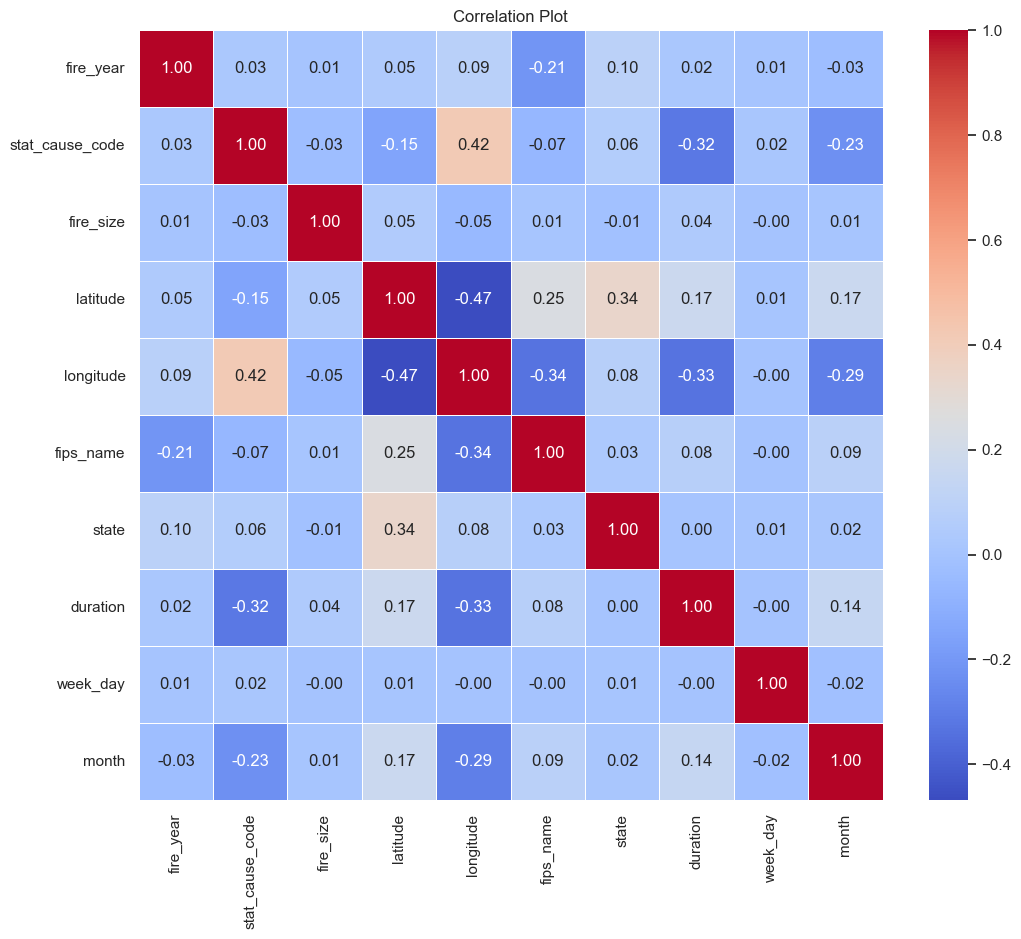

In [49]:
corr_matrix = c_model.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

### Feature Importances

Feature Importance:
     Feature  Importance
3  longitude    0.242512
2   latitude    0.169237
6   duration    0.149939
8      month    0.111717
0  fire_year    0.085173
1  fire_size    0.082495
7   week_day    0.060130
4  fips_name    0.058760
5      state    0.040039


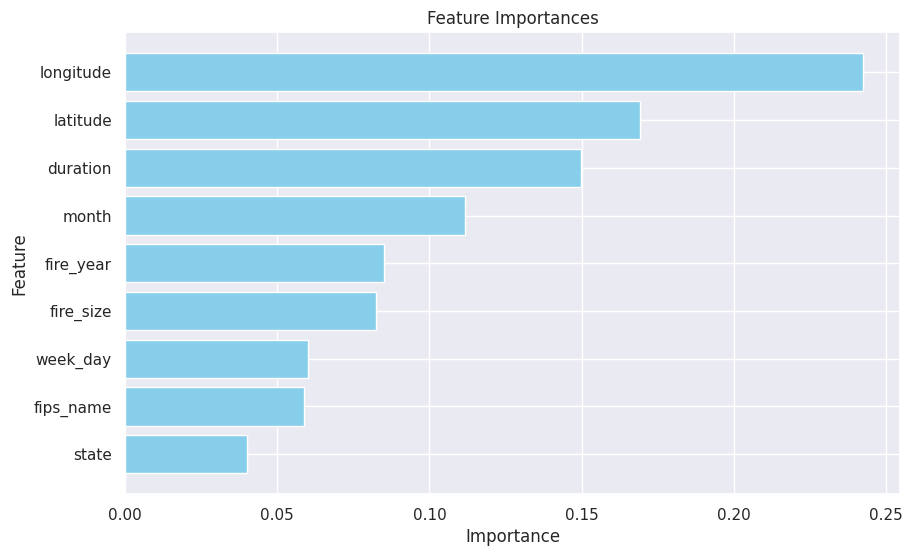

In [21]:
# Get feature importances
feature_importances = ctrain.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': c_model.drop(['stat_cause_code'], axis=1).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance DataFrame
print("Feature Importance:")
print(feature_importance_df)

# Plotting feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

## Apply Model on Original Dataframe and Export Predicted Results

In [22]:
# apply the same data cleaning and feature engineering steps to the original dataframe

# final_df = cleaned_df[["fire_year","discovery_doy","discovery_time","discovery_date","cont_doy","cont_time",
#                        "stat_cause_code","stat_cause_descr","fire_size","latitude","longitude","state","fips_name"]]
final_df = cleaned_df.copy()
final_df["cont_time"] = final_df["cont_time"].astype(str)
final_df["combined_date_dis"] = pd.to_datetime(final_df["fire_year"] * 1000 + final_df["discovery_doy"], format="%Y%j")
final_df["combined_date_dis"] = final_df["combined_date_dis"].astype(str) + " " + final_df["discovery_time"].astype(str).str[:2] + ":" + final_df["discovery_time"].astype(str).str[2:]
final_df["combined_date_dis"] = pd.to_datetime(final_df["combined_date_dis"], errors="coerce")
final_df["combined_date_con"] = pd.to_datetime(final_df["fire_year"] * 1000 + final_df["cont_doy"], format="%Y%j", errors="ignore")
final_df["combined_date_con"] = final_df["combined_date_con"].astype(str) + " " + final_df["cont_time"].str[:2] + ":" + final_df["cont_time"].str[2:]
final_df["combined_date_con"] = pd.to_datetime(final_df["combined_date_con"], errors="coerce")
final_df["duration"] = (final_df["combined_date_con"] - final_df["combined_date_dis"]).dt.seconds / 60
final_df["week_day"] = final_df["combined_date_dis"].dt.weekday
final_df["month"] = final_df["combined_date_dis"].dt.month
final_df = final_df.set_index("combined_date_dis")

final_df["stat_cause_code"] = final_df.stat_cause_code.astype(int)
final_df = final_df[~final_df['stat_cause_code'].isin([9, 13])]

fips_labels = fipslabelencode.fit_transform(final_df.fips_name)
final_df["fips_name"] = fips_labels
state_labels = statelabelencoders.fit_transform(final_df.state)
final_df["state"] = state_labels

/tmp/ipykernel_21987/3829411395.py:10: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  final_df["combined_date_con"] = pd.to_datetime(final_df["fire_year"] * 1000 + final_df["cont_doy"], format="%Y%j", errors="ignore")
/tmp/ipykernel_21987/3829411395.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_df["combined_date_con"] = pd.to_datetime(final_df["combined_date_con"], errors="coerce")


In [23]:
final_df.head()

,objectid,fod_id,fpa_id,source_system_type,source_system,nwcg_reporting_agency,nwcg_reporting_unit_id,nwcg_reporting_unit_name,source_reporting_unit,source_reporting_unit_name,local_incident_id,fire_name,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,owner_code,owner_descr,state,county,fips_code,fips_name,shape,temp_mean_0,prcp_sum_0,wspd_mean_0,temp_mean_10,prcp_sum_10,wspd_mean_10,temp_mean_30,prcp_sum_30,wspd_mean_20,temp_mean_60,prcp_sum_60,wspd_mean_60,temp_mean_180,prcp_sum_180,wspd_mean_180,combined_date_con,duration,week_day,month
combined_date_dis,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NaT,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,PIGEON,2004,2453137.5,133,845.0,1,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,4,61.0,61.0,1180,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,6.8,0.0,9.5,10.155,5.5,13.870000,8.133333,6.0,13.038333,8.100847,6.0,11.572881,3.219101,107.5,10.496348,2004-05-12 15:30:00,NaN,NaN,NaN
2004-05-31 19:00:21,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,021,SLACK,2004,2453156.5,152,1921.0,5,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,4,17.0,17.0,486,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,17.3,0.0,NaN,12.030,0.0,9.711111,11.323333,5.5,10.455172,10.087931,6.0,11.286538,6.210651,107.5,10.915244,2004-05-31 20:24:00,83.65,0.0,5.0
2004-06-28 16:00:00,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,6,DEER,2004,2453184.5,180,1600.0,1,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,4,3.0,3.0,28,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.0,8.930000,11.035000,0.0,10.126667,4.577326,0.0,9.742105,2004-07-03 14:00:00,1320.00,0.0,6.0
2004-06-28 16:00:00,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,7,STEVENOT,2004,2453184.5,180,1600.0,1,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,4,3.0,3.0,28,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.0,8.930000,11.035000,0.0,10.126667,4.577326,0.0,9.742105,2004-07-03 12:00:00,1200.00,0.0,6.0
2004-06-30 18:00:00,6,6,FS-1418849,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,8,HIDDEN,2004,2453186.5,182,1800.0,1,Lightning,2453187.5,183.0,1600.0,0.10,A,38.635278,-120.103611,5.0,USFS,4,5.0,5.0,29,b'\x00\x01\xad\x10\x00\x00\xf0<~\x90\xa1\x06^\...,11.7,0.0,7.9,14.330,0.0,7.650000,13.306667,0.0,8.906667,11.168333,0.0,10.138333,4.757558,0.0,9.579532,2004-07-01 16:00:00,1320.00,2.0,6.0


In [24]:
# get predicted results
predicted = ctrain.predict(final_df[["fire_year","fire_size","latitude","longitude","fips_name",
                                     "state","duration","week_day","month"]])
print(predicted)

/home/jakeli/.pyenv/versions/3.12.2/envs/wildfire/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[1 5 1 ... 1 1 1]


In [26]:

predicted_prob = ctrain.predict_proba(final_df[["fire_year","fire_size","latitude","longitude","fips_name",
                                                "state","duration","week_day","month"]])
print(predicted_prob)

/home/jakeli/.pyenv/versions/3.12.2/envs/wildfire/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[[0.53 0.14 0.02 ... 0.   0.02 0.  ]
 [0.02 0.04 0.01 ... 0.   0.02 0.  ]
 [1.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.34 0.18 0.01 ... 0.05 0.03 0.  ]
 [0.33 0.23 0.1  ... 0.01 0.02 0.01]
 [0.75 0.05 0.   ... 0.03 0.01 0.  ]]


In [29]:
predicted_prob[0]

array([0.53, 0.14, 0.02, 0.21, 0.03, 0.01, 0.02, 0.02, 0.  , 0.02, 0.  ])

In [28]:
# append predicted results to dataframe
final_df['predicted_wildfire_cause_label'] = predicted

export_df = final_df.merge(wildfires_causes_df, how='left', left_on='predicted_wildfire_cause_label', right_on='stat_cause_code')
export_df.rename(columns = {'stat_cause_descr_y': 'predicted_wildfire_cause'}, inplace = True) 
export_df.drop('stat_cause_code_y', axis=1, inplace=True)

export_df.head()

,objectid,fod_id,fpa_id,source_system_type,source_system,nwcg_reporting_agency,nwcg_reporting_unit_id,nwcg_reporting_unit_name,source_reporting_unit,source_reporting_unit_name,local_incident_id,fire_name,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code_x,stat_cause_descr_x,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,owner_code,owner_descr,state,county,fips_code,fips_name,shape,temp_mean_0,prcp_sum_0,wspd_mean_0,temp_mean_10,prcp_sum_10,wspd_mean_10,temp_mean_30,prcp_sum_30,wspd_mean_20,temp_mean_60,prcp_sum_60,wspd_mean_60,temp_mean_180,prcp_sum_180,wspd_mean_180,combined_date_con,duration,week_day,month,predicted_wildfire_cause_label,predicted_wildfire_cause
0,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,PIGEON,2004,2453137.5,133,845.0,1,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,4,61.0,61.0,1180,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,6.8,0.0,9.5,10.155,5.5,13.870000,8.133333,6.0,13.038333,8.100847,6.0,11.572881,3.219101,107.5,10.496348,2004-05-12 15:30:00,NaN,NaN,NaN,1,Lightning
1,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,021,SLACK,2004,2453156.5,152,1921.0,5,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,4,17.0,17.0,486,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,17.3,0.0,NaN,12.030,0.0,9.711111,11.323333,5.5,10.455172,10.087931,6.0,11.286538,6.210651,107.5,10.915244,2004-05-31 20:24:00,83.65,0.0,5.0,5,Debris Burning
2,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,6,DEER,2004,2453184.5,180,1600.0,1,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,4,3.0,3.0,28,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.0,8.930000,11.035000,0.0,10.126667,4.577326,0.0,9.742105,2004-07-03 14:00:00,1320.00,0.0,6.0,1,Lightning
3,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,7,STEVENOT,2004,2453184.5,180,1600.0,1,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,4,3.0,3.0,28,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.0,8.930000,11.035000,0.0,10.126667,4.577326,0.0,9.742105,2004-07-03 12:00:00,1200.00,0.0,6.0,1,Lightning
4,6,6,FS-1418849,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,8,HIDDEN,2004,2453186.5,182,1800.0,1,Lightning,2453187.5,183.0,1600.0,0.10,A,38.635278,-120.103611,5.0,USFS,4,5.0,5.0,29,b'\x00\x01\xad\x10\x00\x00\xf0<~\x90\xa1\x06^\...,11.7,0.0,7.9,14.330,0.0,7.650000,13.306667,0.0,8.906667,11.168333,0.0,10.138333,4.757558,0.0,9.579532,2004-07-01 16:00:00,1320.00,2.0,6.0,1,Lightning


In [ ]:
# export final dataframe with prediction results
export_df.to_csv('final_df_with_results.csv', index=False)

## More Data Visualization

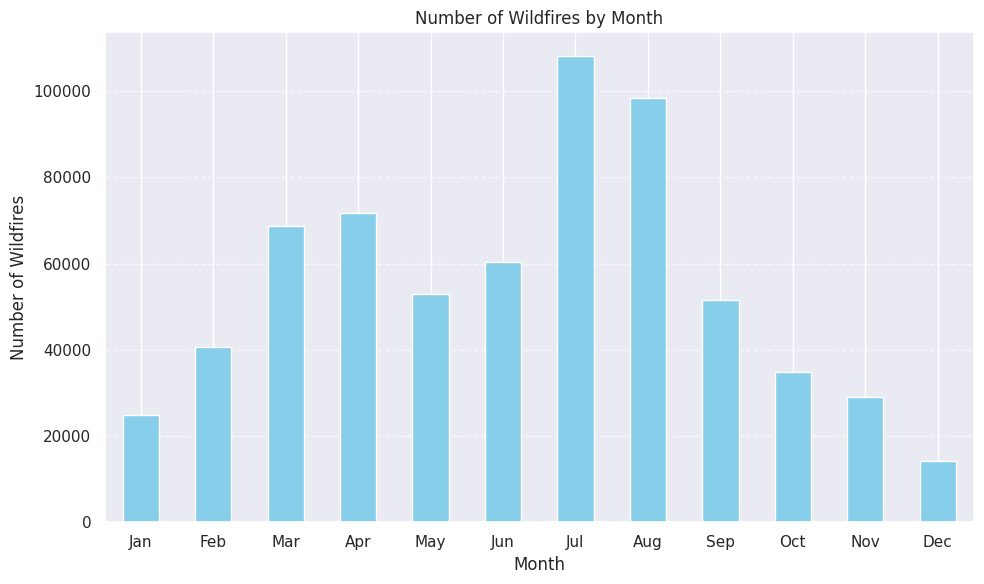

In [30]:
import calendar

final_df['combined_date_con'] = pd.to_datetime(final_df['combined_date_con'])

monthly_counts = final_df.groupby(final_df['combined_date_con'].dt.month).size()

monthly_counts.index = monthly_counts.index.map(lambda x: calendar.month_abbr[int(x)])

# Plotting
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Wildfires by Month')
plt.xlabel('Month')
plt.ylabel('Number of Wildfires')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


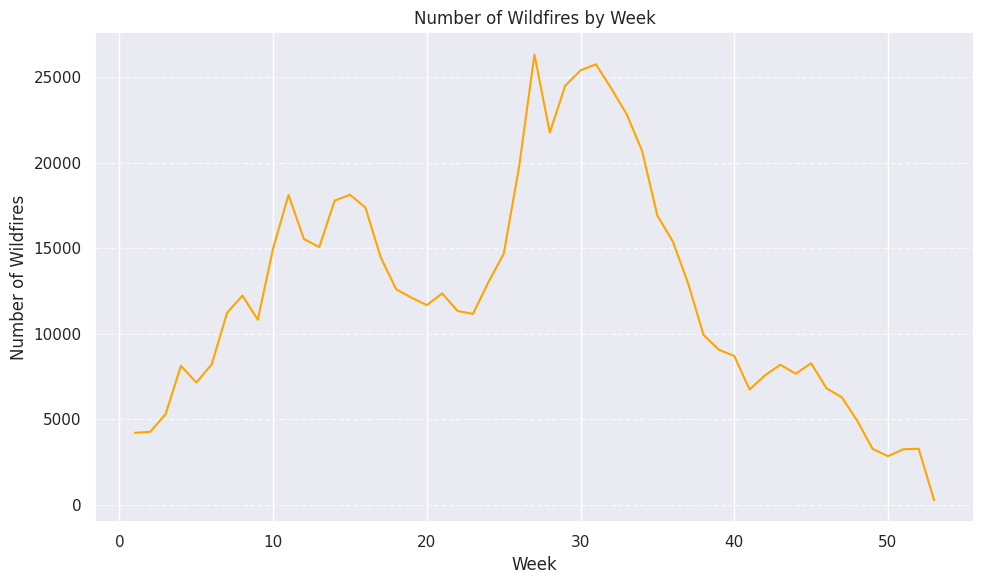

In [31]:
# Convert 'combined_date_con' to datetime format
final_df['combined_date_con'] = pd.to_datetime(final_df['combined_date_con'])

# Group the data by week and count the number of wildfires in each week
weekly_counts = final_df.groupby(final_df['combined_date_con'].dt.isocalendar().week).size()

# Plotting
plt.figure(figsize=(10, 6))
weekly_counts.plot(kind='line', color='orange')
plt.title('Number of Wildfires by Week')
plt.xlabel('Week')
plt.ylabel('Number of Wildfires')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

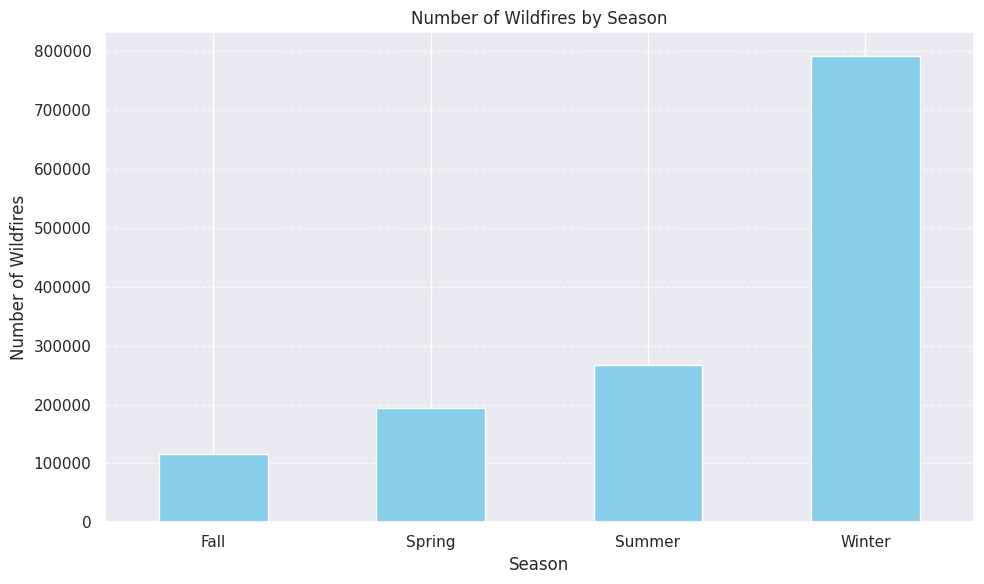

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

final_df['combined_date_con'] = pd.to_datetime(final_df['combined_date_con'])

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Create a new column 'season' by mapping each month to its corresponding season
final_df['season'] = final_df['combined_date_con'].dt.month.map(get_season)

# Group the DataFrame by season and calculate the number of occurrences in each season
seasonal_counts = final_df.groupby('season').size()

# Plotting
plt.figure(figsize=(10, 6))
seasonal_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Wildfires by Season')
plt.xlabel('Season')
plt.ylabel('Number of Wildfires')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Seasonal Decomposition to observe Trends and Seasonal with Residual chart

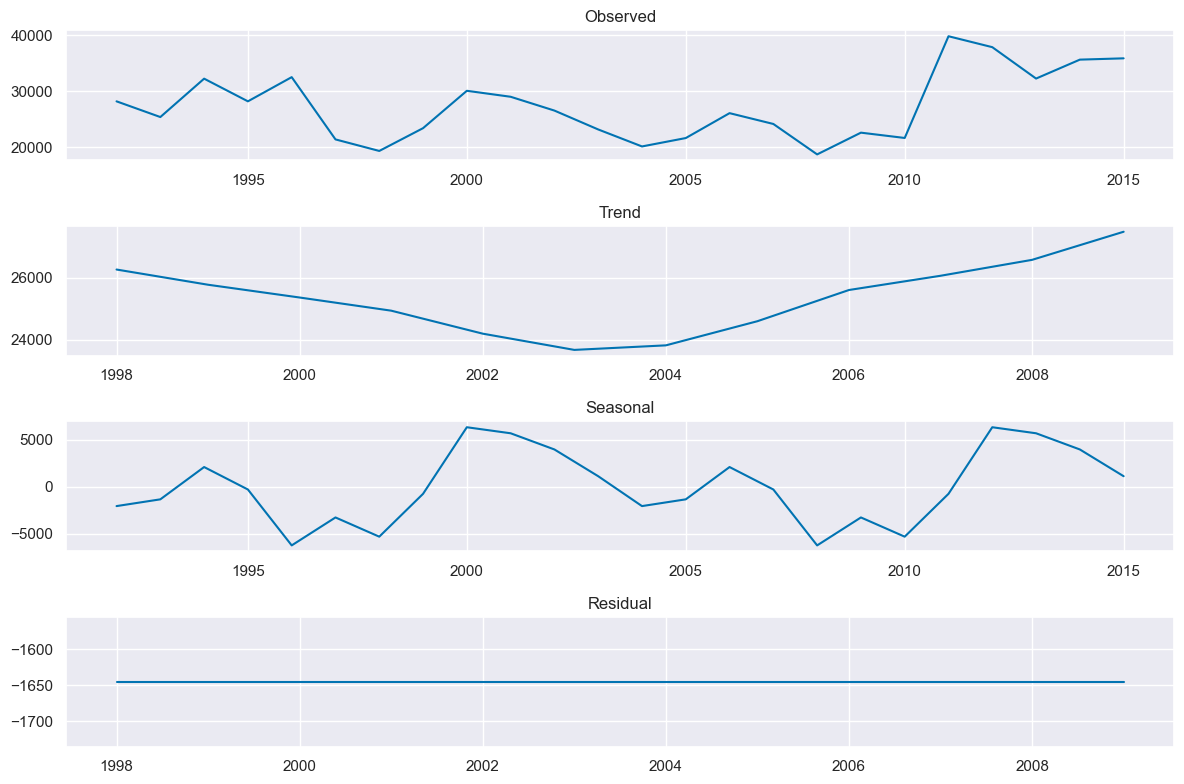

In [48]:

final_df['combined_date_con'] = pd.to_datetime(final_df['combined_date_con'])

final_df['year'] = final_df['combined_date_con'].dt.year

monthly_counts = final_df.groupby([final_df['combined_date_con'].dt.month, final_df['year']]).size()

monthly_counts_df = monthly_counts.unstack(level=1)

monthly_counts_df = monthly_counts_df.fillna(0)

# Aggregate monthly counts to yearly counts
yearly_counts = monthly_counts_df.sum(axis=0)

# Perform seasonal decomposition on yearly counts
result = seasonal_decompose(yearly_counts, model='additive', period=12)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(result.observed)
plt.title('Observed')

plt.subplot(412)
plt.plot(result.trend)
plt.title('Trend')

plt.subplot(413)
plt.plot(result.seasonal)
plt.title('Seasonal')

plt.subplot(414)
plt.plot(result.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()
